In [1]:

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn



from classVEGAS import *
import numpy as np
import time
from classMLMC import MLMC
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt

In [2]:
dim=7
std = 0.1
def func(x):
    a=std
    factor = (1/(a*np.sqrt(np.pi)))**dim
    return np.exp(-np.sum((x-0.5)**2/a**2,axis=-1))*factor

Xtemp = np.random.rand(10000000,dim)
ytemp = func(Xtemp)
I_true = np.mean(ytemp)
print(I_true)

1.0160344439428082


### Cell for finding the best hyperparameters of the NN
X_train = np.random.rand(int(10**4),dim)
y_train = func(X_train)

X_test = np.random.rand(int(10**3),dim)
y_test = func(X_test)


estimator = MLMC(MLPRegressor(hidden_layer_sizes=[100,100,100], activation="tanh", solver="lbfgs"),
            split_train_percent=50,
            integration_boundries=[0,1],
            dims=dim,
            verbose=True) 

imc, imlmc = estimator.get_estimates(X_train, y_train, X_test)

y_pred = estimator.regressor.predict(X_test)
error = np.mean(np.abs(y_pred-y_test)/np.abs(y_test))
print(error)

In [3]:
Nrep = 5
Ns = np.logspace(3,6,10)
M = 10**5

I_mc = np.zeros((Nrep,len(Ns)))
I_mlmc = np.zeros_like(I_mc)

In [4]:
for rep in range(Nrep):
    print("Repetition {}".format(rep))
    for i,n in enumerate(Ns):
        print("Using {} true samples and {} surrogate samples".format(n,M))
        Xtrain = np.random.rand(int(np.floor(n)),dim)
        ytrain = func(Xtrain)
        Xtest = np.random.rand(M,dim)

        estimator = MLMC(MLPRegressor(hidden_layer_sizes=[200,200], activation="tanh", solver="adam",max_iter=300),
            split_train_percent=50,
            integration_boundries=[0,1],
            dims=dim,
            verbose=True)

        imc, imlmc = estimator.get_estimates(Xtrain, ytrain, Xtest)

        I_mc[rep,i] = imc
        I_mlmc[rep,i] = imlmc




Repetition 0
Using 1000.0 true samples and 100000 surrogate samples
Using 2154.4346900318847 true samples and 100000 surrogate samples
Using 4641.588833612777 true samples and 100000 surrogate samples
Using 10000.0 true samples and 100000 surrogate samples
Using 21544.346900318822 true samples and 100000 surrogate samples
Using 46415.888336127726 true samples and 100000 surrogate samples
Using 100000.0 true samples and 100000 surrogate samples
Using 215443.46900318822 true samples and 100000 surrogate samples
Using 464158.8833612772 true samples and 100000 surrogate samples
Using 1000000.0 true samples and 100000 surrogate samples
Repetition 1
Using 1000.0 true samples and 100000 surrogate samples
Using 2154.4346900318847 true samples and 100000 surrogate samples
Using 4641.588833612777 true samples and 100000 surrogate samples
Using 10000.0 true samples and 100000 surrogate samples
Using 21544.346900318822 true samples and 100000 surrogate samples
Using 46415.888336127726 true samples

In [5]:
iterations=100
intervals=30
samples_per_it=10000

estimates = np.zeros((Nrep,iterations))
mean_vegas_error = np.zeros(iterations)

for rep in range(Nrep):
    estimator=Vegas(integrand=func,
                    dims=dim,
                    intervals=intervals,
                    samples=samples_per_it,
                    iterations=iterations,
                    K=100,
                    alpha=2.0)
    estimator.get_estimate()
    estimates[rep,:] = estimator.cumulative_integral

for it in range(iterations):
    mean_vegas_error[it] = np.mean(np.abs(1.0-estimates[:,it]))

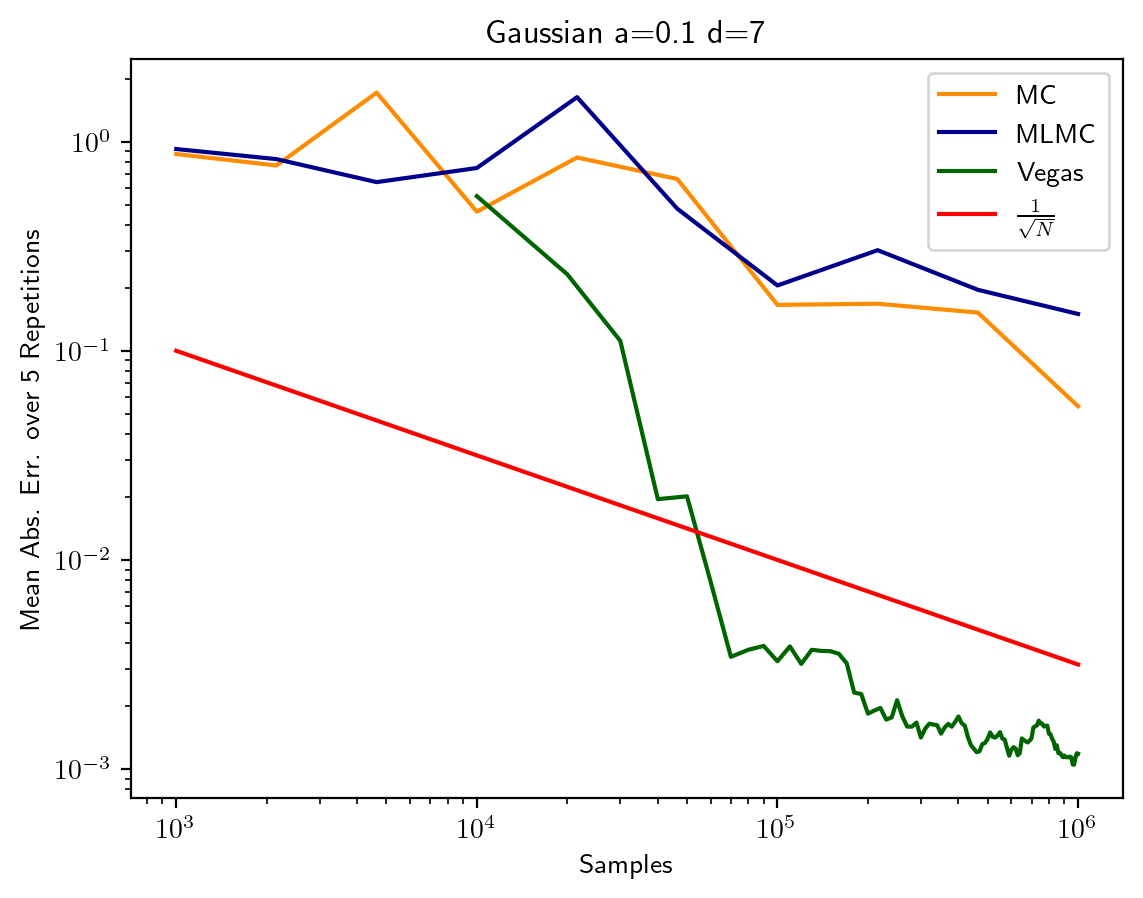

In [6]:
mean_mc_error = np.zeros(len(Ns))
mean_mlmc_error = np.zeros(len(Ns))

for i in range(len(Ns)):
    mean_mc_error[i] = np.mean(np.abs(1.0-I_mc[:,i]))
    mean_mlmc_error[i] = np.mean(np.abs(1.0-I_mlmc[:,i]))

plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(dpi=200)
ax.set_xlabel("Samples")
ax.set_ylabel("Mean Abs. Err. over {} Repetitions".format(Nrep))
ax.set_title("Gaussian a={} d={}".format(std, dim))
#ax.set_ylim(-0,0.1)
ax.set_xscale("log")
ax.set_yscale("log")
'''
ax.fill_between(Ns, 0, mean_mc_error, color = "darkorange", hatch = '//', edgecolor = 'black', label="MC", zorder=1, alpha=1)
ax.fill_between(Ns, 0, mean_mlmc_error, color = "darkblue", hatch = '\\', edgecolor = 'black', label="MLMC", zorder=3, alpha=1)
ax.fill_between(np.linspace(samples_per_it,samples_per_it*iterations,iterations), mean_vegas_error, color="darkgreen", hatch = '||', edgecolor = 'black', label="Vegas", zorder=2,alpha=0.9)
'''
ax.plot(Ns, mean_mc_error, color = "darkorange", label="MC")
ax.plot(Ns, mean_mlmc_error, color = "darkblue", label="MLMC")
ax.plot(np.linspace(samples_per_it,samples_per_it*iterations,iterations), mean_vegas_error, color="darkgreen", label="Vegas")
ax.plot(np.linspace(1000,1000000,1000), 1/(np.sqrt(np.linspace(100,100000,1000))), color="red", label=r'$\frac{1}{\sqrt{N}}$')
ax.legend()